In [167]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# machine learning
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer

import scipy.stats as stats

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

# MODEL DATA

We checked for linearity in the first part of the project. Now we are checking out the next two assumptions — normality and homoscedasticity. This requires us to first create a regression model because they refer to a model’s residuals rather than its features. 

This part of the project includes:

1. Fitting an initial regression model, and then conducting statistical analyses of the results. We'll take a look at the p-values of the various features and perform some feature selection. We'll test for regression assumptions including normality, heteroscedasticity, and independence. 
2. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.

## Fitting an Initial Model

In [168]:
#read our dataframe
preprocessed = pd.read_csv('./Data & Figures/preprocessed.csv', index_col = 0)
preprocessed.head()

,price,bedrooms,bathrooms,grade,sqft_above,sqft_basement,sqft_living15,zip_A,zip_B,zip_C,...,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,water_1.0,cond_2.0,cond_3.0,cond_4.0,cond_5.0
15937,268950.0,3,1.00,6,880,440.0,1000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20963,399900.0,2,1.75,9,900,510.0,1440,0,0,0,...,1,0,0,0,0,0,0,1,0,0
7614,339000.0,3,1.00,7,720,380.0,1510,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3257,380000.0,2,1.00,7,840,200.0,1930,1,0,0,...,0,0,0,0,0,0,0,0,0,1
16723,365000.0,5,2.00,7,1600,0.0,1190,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [169]:
preprocessed.columns

Index(['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'floors_1.5', 'floors_2.0',
       'floors_2.5', 'floors_3.0', 'floors_3.5', 'water_1.0', 'cond_2.0',
       'cond_3.0', 'cond_4.0', 'cond_5.0'],
      dtype='object')

In [170]:
features = ['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'floors_1.5', 'floors_2.0',
       'floors_2.5', 'floors_3.0', 'floors_3.5', 'water_1.0', 'cond_2.0',
       'cond_3.0', 'cond_4.0', 'cond_5.0']

### Perform Stepwise Selection

In [171]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05.
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [172]:
#apply function
X = preprocessed.drop('price', axis=1)
y = preprocessed['price']

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  grade                          with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_A                          with p-value 0.0


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  zip_C                          with p-value 0.0
Add  sqft_above                     with p-value 0.0


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_basement                  with p-value 0.0
Add  zip_B                          with p-value 9.63715e-226


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_living15                  with p-value 3.08946e-101
Add  cond_3.0                       with p-value 5.59705e-86


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  zip_G                          with p-value 2.127e-87
Add  bedrooms                       with p-value 1.58466e-52


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  floors_2.0                     with p-value 5.64044e-44
Add  zip_F                          with p-value 2.23811e-42


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  cond_5.0                       with p-value 4.13846e-22
Add  zip_E                          with p-value 5.16605e-19


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  zip_I                          with p-value 6.27568e-23
Add  floors_1.5                     with p-value 1.87637e-14


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  floors_2.5                     with p-value 4.15382e-13
Add  floors_3.0                     with p-value 8.47335e-08


<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-171-4d1c4df4fb84>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bathrooms                      with p-value 0.00991749
resulting features:
['grade', 'water_1.0', 'zip_A', 'zip_C', 'sqft_above', 'sqft_basement', 'zip_B', 'sqft_living15', 'cond_3.0', 'zip_G', 'bedrooms', 'floors_2.0', 'zip_F', 'cond_5.0', 'zip_E', 'zip_I', 'floors_1.5', 'floors_2.5', 'floors_3.0', 'bathrooms']


In [173]:
#build initial model again in statsmodels
import statsmodels.api as sm

X_fin = X[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     2398.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:24:00   Log-Likelihood:            -2.8740e+05
No. Observations:               21229   AIC:                         5.748e+05
Df Residuals:                   21208   BIC:                         5.750e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.16e+05   1.23e+04    -50.000      0.000    -6.4e+05   -5.92e+05
grade          8.491e+04   1968.837     43.127      0.000    8.11e+04    8.88e+04
water_1.0      7.334e+05   1.62e+04     45.161      0.000    7.02e+05    7.65e+05
zip_A          2.689e+05   4234.702     63.490      0.000    2.61e+05    2.77e+05
zip_C          2.533e+05   5113.818     49.530      0.000    2.43e+05    2.63e+05
sqft_above      164.2420      3.532     46.497      0.000     157.318     171.166
sqft_basement   144.0475      4.100     35.132      0.000     136.011     152.084
zip_B          1.633e+05   4843.803     33.718      0.000    1.54e+05    1.73e+05
sqft_living15    60.8468      3.240     18.778      0.000      54.496      67.198
cond_3.0      -4.173e+04   3082.338    -13.537      0.000   -4.78e+04   -3.57e+04
zip_G          1.123e+05   5590.476     20.091      0.000    1.01e+05    1.23e+05
bedrooms      -2.836e+04   1853.742    -15.300      0.000    -3.2e+04   -2.47e+04
floors_2.0    -4.426e+04   4008.097    -11.042      0.000   -5.21e+04   -3.64e+04
zip_F         -4.232e+04   5593.152     -7.566      0.000   -5.33e+04   -3.14e+04
cond_5.0        4.75e+04   5144.307      9.233      0.000    3.74e+04    5.76e+04
zip_E          6.517e+04   6058.690     10.757      0.000    5.33e+04     7.7e+04
zip_I          8.192e+04   8297.296      9.873      0.000    6.57e+04    9.82e+04
floors_1.5     3.623e+04   4896.180      7.399      0.000    2.66e+04    4.58e+04
floors_2.5     1.004e+05   1.54e+04      6.518      0.000    7.02e+04    1.31e+05
floors_3.0    -5.052e+04   8645.586     -5.844      0.000   -6.75e+04   -3.36e+04
bathrooms      7697.6928   2984.845      2.579      0.010    1847.170    1.35e+04
==============================================================================
Omnibus:                    13158.231   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           315866.326
Skew:                           2.566   Prob(JB):                         0.00
Kurtosis:                      21.187   Cond. No.                     3.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [174]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 10)
selector = selector.fit(X, y.values.ravel()) # convert y to 1d np array to prevent DataConversionWarning
selector.support_

array([False, False,  True, False, False, False,  True, False,  True,
        True, False,  True, False,  True, False, False, False,  True,
        True,  True,  True, False, False, False, False])

In [175]:
X[selected_columns]

,grade,zip_C,zip_D,zip_F,zip_H,floors_2.5,floors_3.5,water_1.0
15937,6,0,0,0,0,0,0,0
20963,9,0,0,0,0,0,0,0
7614,7,0,0,0,0,0,0,0
3257,7,0,0,0,0,0,0,0
16723,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
3553,7,0,0,0,0,0,0,0
8800,6,0,0,0,0,0,0,0
8404,7,0,0,0,0,0,0,0
6729,8,0,0,0,0,0,0,0


In [176]:
#fit the linear regression model again using the 5 selected columns
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)

LinearRegression()

In [177]:
#predict yhat using our model
yhat = linreg.predict(X[selected_columns])
yhat

array([200704.76717282, 750209.16453097, 501608.61361591, ...,
       383872.89962554, 567041.03207825, 203226.4073891 ])

In [178]:
#compute R-squared and contrast them with the R-squared and adjusted R-squared in our statsmodels output using stepwise selection
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)

print('r_squared:', r_squared)
print('adjusted_r_squared:', adjusted_r_squared)

r_squared: 0.5940813754530198
adjusted_r_squared: 0.5938900668355502


Our r_squared and adjusted_r_squared are very very similar: 59% of the dataset's variation from the mean can be explained by our model.

In [180]:
linreg.intercept_

-898304.0275434698

In [181]:
coefficients = dict(zip(X,list(linreg.coef_)))
coefficients

{'bedrooms': 183168.13245271536,
 'bathrooms': 117735.71399037297,
 'grade': 162124.5116435496,
 'sqft_above': -128831.26756013624,
 'sqft_basement': -180646.4922364398,
 'sqft_living15': -125454.60191972998,
 'zip_A': 171231.08847836158,
 'zip_B': -144472.01070879534,
 'zip_C': 120770.03538696565,
 'zip_D': 800308.5878165263}

In [182]:
['{} Bedrooms: +${}'.format(i, round(coefficients['bedrooms'] * np.log(i), 0))
 for i in range(1,6)]

['1 Bedrooms: +$0.0',
 '2 Bedrooms: +$126962.0',
 '3 Bedrooms: +$201231.0',
 '4 Bedrooms: +$253925.0',
 '5 Bedrooms: +$294798.0']

In [185]:
['{} Bathrooms: +${}'.format(i, round(coefficients['bathrooms'] * np.log(i), 0))
 for i in range(1,6)]

['1 Bathrooms: +$0.0',
 '2 Bathrooms: +$81608.0',
 '3 Bathrooms: +$129346.0',
 '4 Bathrooms: +$163216.0',
 '5 Bathrooms: +$189488.0']

In [183]:
['Grade {}: +${}'.format(i, round(coefficients['grade'] * np.log(i), 0))
 for i in range(5,13)]

['Grade 5: +$260929.0',
 'Grade 6: +$290488.0',
 'Grade 7: +$315480.0',
 'Grade 8: +$337128.0',
 'Grade 9: +$356224.0',
 'Grade 10: +$373305.0',
 'Grade 11: +$388758.0',
 'Grade 12: +$402864.0']

In [186]:
['Square Footage Above {}: +${}'.format(i, round(coefficients['sqft_above'] * np.log(i), 0))
 for i in range(5,13)]

['Square Footage Above 5: +$-207346.0',
 'Square Footage Above 6: +$-230835.0',
 'Square Footage Above 7: +$-250694.0',
 'Square Footage Above 8: +$-267897.0',
 'Square Footage Above 9: +$-283071.0',
 'Square Footage Above 10: +$-296645.0',
 'Square Footage Above 11: +$-308924.0',
 'Square Footage Above 12: +$-320134.0']

In [187]:
['Square Footage Basement {}: +${}'.format(i, round(coefficients['sqft_basement'] * np.log(i), 0))
 for i in range(5,13)]

['Square Footage Basement 5: +$-290739.0',
 'Square Footage Basement 6: +$-323675.0',
 'Square Footage Basement 7: +$-351522.0',
 'Square Footage Basement 8: +$-375644.0',
 'Square Footage Basement 9: +$-396921.0',
 'Square Footage Basement 10: +$-415954.0',
 'Square Footage Basement 11: +$-433171.0',
 'Square Footage Basement 12: +$-448890.0']

In [188]:
['Square Footage Living of the Nearest 15 Neighbors {}: +${}'.format(i, round(coefficients['sqft_living15'] * np.log(i), 0))
 for i in range(5,13)]

['Square Footage Living of the Nearest 15 Neighbors 5: +$-201911.0',
 'Square Footage Living of the Nearest 15 Neighbors 6: +$-224784.0',
 'Square Footage Living of the Nearest 15 Neighbors 7: +$-244123.0',
 'Square Footage Living of the Nearest 15 Neighbors 8: +$-260876.0',
 'Square Footage Living of the Nearest 15 Neighbors 9: +$-275652.0',
 'Square Footage Living of the Nearest 15 Neighbors 10: +$-288870.0',
 'Square Footage Living of the Nearest 15 Neighbors 11: +$-300827.0',
 'Square Footage Living of the Nearest 15 Neighbors 12: +$-311743.0']

### Test Initial Model

In [190]:
#fit the linear regression model again using the selected columns
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)

LinearRegression()

In [191]:
#predict yhat using our model
yhat = linreg.predict(X[selected_columns])

In [192]:
#check out selected columns/ features
X[selected_columns]

,grade,zip_A,zip_C,zip_D,zip_F,zip_H,floors_2.5,floors_3.0,floors_3.5,water_1.0
15937,6,0,0,0,0,0,0,0,0,0
20963,9,0,0,0,0,0,0,0,0,0
7614,7,1,0,0,0,0,0,0,0,0
3257,7,1,0,0,0,0,0,0,0,0
16723,7,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3553,7,1,0,0,0,0,0,0,0,0
8800,6,0,0,0,0,0,0,0,0,0
8404,7,0,0,0,0,0,0,0,0,0
6729,8,0,0,0,0,0,0,0,0,0


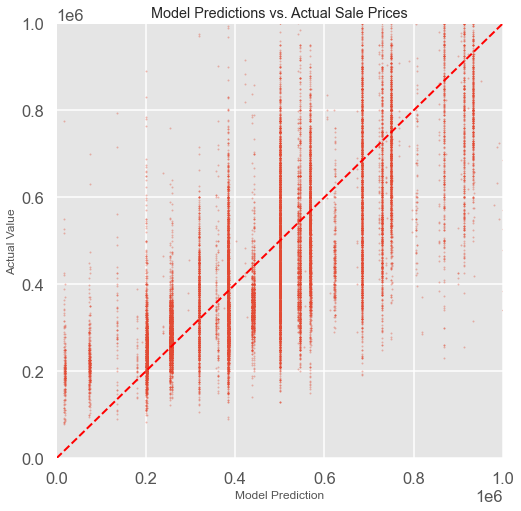

In [193]:
plt.figure(figsize = (8,8))

plt.scatter(yhat, y, s=2, alpha = 0.3)
plt.plot([0,1000000], [0,1000000], color='red', ls='--')

plt.xlim(0,1000000)
plt.ylim(0,1000000)

plt.title('Model Predictions vs. Actual Sale Prices')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');

### Validate Initial Model

In [194]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train), len(y_train), len(X_test), len(y_test))

15921 15921 5308 5308


In [195]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

In [196]:
#fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression()

In [197]:
#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [198]:
#cbalculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [199]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

34151928532.563366
32126333411.1959


### Assessing the Model

When performing an initial assessment of the model we focus on a number of different perspectives such as r2 and MSE (mean square error). We want to know the underlying influencers and how those can be adjusted in order to increase or decrease the target 'price'. Such metrics would include p-values associated with the various features, comparing models with features removed and investigating potential multicollinearity in the model.

### Comments on P-Values

Based on the p-values above, you can see that there are a number of extraneous features. Recall that a common significance cutoff is 0.05. The refined model should eliminate these irrelevant features.

**Comments:** Note that while the  𝑟2  value did drop, it did so only marginally despite dropping 6/10 of the original features. Additionally, all of the p-values indicate that all of the current features are substantially influential.

### Additional Assessments and Refinement

**Comment:** While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables. With that, it makes sense to briefly update the features once again and recheck for multicollinearity.

## Model Refinement 1

### Rechecking Normality

### Rechecking Homoscedasticity

## Model Refinement 2: Interactions

# REGRESSION MODEL VALIDATION

In order to get a good sense of how well your model will be doing on new instances, you'll have to perform a so-called "train-test-split". What you'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets  𝑦  and the fitted  𝑦̂   obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

## Train-Test Split

To evaluate the model, you'll want to compare your predicted values,  𝑦̂   with the actual value,  𝑦 . The difference between the two values is referred to as the residuals. When using a train-test split, you'll compare your residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the (Root) Mean Squared Error. A big difference in value between the test and training set (R)MSE is an indication of overfitting.

Look at the residuals and calculate the MSE for training and test sets:

## K-Fold Cross Validation

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called K-Fold Cross Validation.

K-Fold Cross Validation expands on the idea of training and test splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

You can easily do this in scikit-learn using cross_val_score(). If you want the mean squared error as an output, you need to set the scoring argument to 'neg_mean_squared_error'

## Bias-Variance Tradeoff

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.